In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os 
from datetime import datetime
import seaborn as sn
import pandas as pd

# show all the output 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Step1: Define Help Functions:

### 1. Help Fucntions for Downloading and Importing Data

In [2]:
# %load ./Data_Loading.py
########################################################################
#
# Functions for downloading the CIFAR-10 data-set from the internet
# and loading it into memory.
#
# Implemented in Python 3.5
#
# Usage:
# 1) Set the variable data_path with the desired storage path.
# 2) Call maybe_download_and_extract() to download the data-set
#    if it is not already located in the given data_path.
# 3) Call load_class_names() to get an array of the class-names.
# 4) Call load_training_data() and load_test_data() to get
#    the images, class-numbers and one-hot encoded class-labels
#    for the training-set and test-set.
# 5) Use the returned data in your own program.
#
# Format:
# The images for the training- and test-sets are returned as 4-dim numpy
# arrays each with the shape: [image_number, height, width, channel]
# where the individual pixels are floats between 0.0 and 1.0.
#
########################################################################
#
# This file is part of the TensorFlow Tutorials available at:
#
# https://github.com/Hvass-Labs/TensorFlow-Tutorials
#
# Published under the MIT License. See the file LICENSE for details.
#
# Copyright 2016 by Magnus Erik Hvass Pedersen
#
########################################################################

import numpy as np
import pickle
import os
import urllib.request
import tarfile
import zipfile

########################################################################

# Directory where you want to download and save the data-set.
# Set this before you start calling any of the functions below.
data_path = "data/CIFAR-10/"

# URL for the data-set on the internet.
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

########################################################################
# Various constants for the size of the images.
# Use these constants in your own program.

# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = 10

########################################################################
# Various constants used to allocate arrays of the correct size.

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

########################################################################
# Private functions for downloading, unpacking and loading data-files.


def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set.
    If filename=="" then return the directory of the files.
    """

    return os.path.join(data_path, "cifar-10-batches-py/", filename)


def _unpickle(filename):
    """
    Unpickle the given file and return the data.
    Note that the appropriate dir-name is prepended the filename.
    """

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file, encoding='bytes')

    return data

def ZCAtrans(raw):
    xm = np.mean(raw, axis = 0)
    raw= raw- xm
    raw2 = raw.reshape((raw.shape[0], -1))
    # raw is assumed to be zero-mean
    C = np.dot( raw2.T, raw2 )/raw2.shape[0]
    U, eva, V = np.linalg.svd(C)  # U[:, i] is the i-th eigenvector
    sqeva = np.sqrt(eva + 0.001)
    Uzca = np.dot(U/sqeva[np.newaxis, :], U.T)
    X = np.dot(raw2, Uzca)
    return X

def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0
    raw_float = ZCAtrans(raw_float)

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])
    
    # normailze each image
    for i in range(images.shape[0]):
        m,M = images[i].min(), images[i].max()
        images[i]=(images[i] - m) / (M - m)

    return images


def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


########################################################################
# Public functions that you may call to download the data-set from
# the internet and load the data into memory.


def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.

    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"

    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,filename=file_path)
                                                  

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")



def load_class_names():
    """
    Load the names for the classes in the CIFAR-10 data-set.
    Returns a list with the names. Example: names[3] is the name
    associated with class-number 3.
    """

    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names

def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-Hot encoded class-labels from an array of integers.
    For example, if class_number=2 and num_classes=4 then
    the one-hot encoded label is the float array: [0. 0. 1. 0.]
    :param class_numbers:
        Array of integers with class-numbers.
        Assume the integers are from zero to num_classes-1 inclusive.
    :param num_classes:
        Number of classes. If None then use max(class_numbers)+1.
    :return:
        2-dim array of shape: [len(class_numbers), num_classes]
    """

    # Find the number of classes if None is provided.
    # Assumes the lowest class-number is zero.
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]

def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.
    The data-set is split into 5 data-files which are merged here.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


def load_test_data():
    """
    Load all the test-data for the CIFAR-10 data-set.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    images, cls = _load_data(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)

########################################################################
## The following is for loading testing data to show the original images
#######################################################################

def _convert_images_for_print(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data_for_print(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images_for_print(raw_images)

    return images, cls

def load_test_data_for_print():
    """
    Load all the test-data for the CIFAR-10 data-set.

    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    images, cls = _load_data_for_print(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


### 2. Help Fucntions for Data Augmentation

In [3]:
# %load ./Data_Augmentation.py
########################################################################
## The function is for data Augmentation:
########################################################################
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

##########################################################
## The function is for apply preprocessiong for all images:
##########################################################
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

### 3. Help Function for Bulding CNN

In [4]:
# %load ./CNN.py
#######################################################
# The function is for compute the cross entropy
#######################################################
def compute_cross_entropy(logits, y):
    sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
    cross_ent = tf.reduce_mean(sm_ce, name='cross_ent')
    return cross_ent


#######################################################
# The function is for compute the cross entropy
#######################################################
def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return  prediction, accuracy

#######################################################
# The function is for geting random batch for training the network
#######################################################
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)
    
    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx,:,:,:]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

######################################################
# The Function for defineing the CNN Network
######################################################
# Inference

def _variable_with_weight_decay(name, shape, stddev, wd):
    """
    Helper to create an initialized Variable with weight decay

    Args:
        name: name of the variable
        shape: list of ints
        stddev: standard deviation of a truncated Gaussian
        wd: add L2Loss weight decay multiplied by this float. If None, weight
            decay is not added for this Variable.

    Returns:
        Variable Tensor
    """
    var = _variable_on_cpu(
        name,
        shape,
        tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var


def _variable_on_cpu(name, shape, initializer):
    """
    Helper to create a Variable stored on CPU memory

    Args:
        name: name of the variable
        shape: list of ints
        initializer: initializer for Variable

    Returns:
        Variable Tensor

    """
    with tf.device('/cpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    return var

def compute_logits_cnn(x):
    
    phase_train = tf.placeholder(tf.bool, name='phase_train')

    x = tf.reshape(x, [-1, img_size_cropped, img_size_cropped, 3])

    # layer_conv1
    with tf.variable_scope('conv1') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 3, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name=scope.name)

    # max_pool
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')

    # layer_conv2
    with tf.variable_scope('conv2') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 64, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name=scope.name) 

    # max_pool
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')
    
    # layer_fc1
    with tf.variable_scope('fc1') as scope:
        # flatten
        reshape = tf.reshape(pool2, [-1, 6*6*64])
        dim = reshape.get_shape()[1].value
        weights = _variable_with_weight_decay('weights', shape=[dim, 256],
                                              stddev=0.04, wd=0.0)
        biases = _variable_on_cpu('biases', [256], tf.constant_initializer(0.0))
        fc1 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)

    # layer_fc2
    with tf.variable_scope('fc2') as scope:
        weights = _variable_with_weight_decay('weights', shape=[256, 128],
                                              stddev=0.04, wd=0.0)
        biases = _variable_on_cpu('biases', [128], tf.constant_initializer(0.0))
        fc2 = tf.nn.relu(tf.matmul(fc1, weights) + biases, name=scope.name)

    # softmax_classifier
    with tf.variable_scope('softmax_linear') as scope:
        weights = _variable_with_weight_decay('weights', [128, num_classes],
                                          stddev=1/128.0, wd=0.0)
        biases = _variable_on_cpu('biases', [num_classes],
                              tf.constant_initializer(0.0))
        softmax_linear = tf.add(tf.matmul(fc2, weights), biases, name=scope.name)   

    return softmax_linear, pool1 , pool2

### 4. Help Function for Building Network in Network

In [31]:
# %load ./NIN.py
#######################################################
# The funciton is for building Network in Network.
#######################################################
def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

def avgpool(x, k = 3, s = 2, p = 'SAME'):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding= p)

def dropout(x):
    """simple wrapper for tf.nn.dropout with dropout ratio 0.5"""
    return tf.nn.dropout(x, 0.5)

## Define the Network
def compute_logits_NIN(x):
    x_image = tf.reshape(x, [-1, img_size_cropped, img_size_cropped, 3])
    # conv1 / relu1
    W_conv1 = tf.get_variable('W_conv1', shape = [5, 5, 3, 96])
    b_conv1 = tf.get_variable('b_conv1', shape = [96],)
    h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
    
    # cccp1 / relu_cccp1
    W_cccp1 = tf.get_variable('W_cccp1', shape = [1, 1, 96, 80])
    b_cccp1 = tf.get_variable('b_cccp1', shape = [80])
    h_cccp1 = tf.nn.relu(tf.add(conv(h_conv1, W_cccp1), b_cccp1))
    
    # cccp2 / relu_cccp2
    W_cccp2 = tf.get_variable('W_cccp2', shape = [1, 1, 80, 48])
    b_cccp2 = tf.get_variable('b_cccp2', shape = [48])
    h_cccp2 = tf.nn.relu(tf.add(conv(h_cccp1, W_cccp2), b_cccp2))
    
    #print(h_cccp2)
    h_pool1 = maxpool(h_cccp2)
    # drop3
    h_drop3 = dropout(h_pool1)
    # conv2 / relu2
    W_conv2 = tf.get_variable('W_conv2', shape = [5, 5, 48, 96])
    b_conv2 = tf.get_variable('b_conv2',shape = [96])
    h_conv2 = tf.nn.relu(tf.add(conv(h_drop3, W_conv2), b_conv2))
    
    # cccp3 / relu_cccp3
    W_cccp3 = tf.get_variable('W_cccp3', shape = [1, 1, 96, 96])
    b_cccp3 = tf.get_variable('b_cccp3', shape = [96])
    h_cccp3 = tf.nn.relu(tf.add(conv(h_conv2, W_cccp3), b_cccp3))
    
    # cccp4 / relu_cccp4
    W_cccp4 = tf.get_variable('W_cccp4', shape = [1, 1, 96, 96])
    b_cccp4 = tf.get_variable('b_cccp4',shape = [96])
    h_cccp4 = tf.nn.relu(tf.add(conv(h_cccp3, W_cccp4), b_cccp4))
    # poo2
    h_pool2 = avgpool(h_cccp4)
    # drop6
    h_drop6 = dropout(h_pool2)
    
    # conv3 / relu3
    W_conv3 = tf.get_variable('W_conv3', shape = [3, 3, 96, 96])
    b_conv3 = tf.get_variable('b_conv3',shape = [96],)
    h_conv3 = tf.nn.relu(tf.add(conv(h_drop6, W_conv3), b_conv3))
    
    # cccp5 / relu_cccp5
    W_cccp5 = tf.get_variable('W_cccp5', shape = [1, 1, 96, 96])
    b_cccp5 = tf.get_variable('b_cccp5', shape = [96])
    h_cccp5 = tf.nn.relu(tf.add(conv(h_conv3, W_cccp5), b_cccp5))
    
    # cccp6 / relu_cccp6
    W_cccp6 = tf.get_variable('W_cccp6', shape = [1, 1, 96, 10])
    b_cccp6 = tf.get_variable('b_cccp6',shape = [10])
    h_cccp6 = tf.nn.relu(tf.nn.bias_add(conv(h_cccp5, W_cccp6), b_cccp6))
    
    # pool3
    h_pool3 = avgpool(h_cccp6, 6, 1, 'VALID')
    output_reshaped = tf.reshape(h_pool3, [-1,10])

    return output_reshaped,h_conv1,h_cccp1,h_cccp2,h_pool1,h_conv2,h_pool2,h_cccp3,h_cccp4,h_conv3,h_cccp5,h_cccp6,h_pool3

###########################################################
#############################################################

### 5. Help Function for Network Visulization and Model Evaluation

In [29]:
# %load ./Visulization.py
########################################################################
# The functions are for showing the original images
########################################################################
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


########################################################################
# The functions are for showing different layer for the networks
########################################################################
def getActivations(sess,layer_name,image_name):
    units = sess.run(layer_name,feed_dict={x:image_name})
    plotNNFilter(units)
    
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

#######################################################
# The function is for obtaining hard assignment for the images and show the confusion matrix
#######################################################
def Test_Anlaysis(sess, images, labels, cls_true):
    
    num_images = len(images)
    # Initialize the predictions
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    
    i = 0
    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = sess.run(prediction, feed_dict={x: images[i:j, :],y_true: labels[i:j, :]})

        # end-index of the current batch.
        i = j
    
    co_ma = confusion_matrix(y_true=cls_true, y_pred=cls_pred) 
    
    # Print the confusion matrix as text.
    print("Confusion Matrix as numbers:")  
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(co_ma[i, :], class_name)
    
    # Print the consusion matrix as graph
    print("Plot Confusion Matrix:")  
    df_cm = pd.DataFrame(co_ma, index = [i for i in class_names],
                  columns = [i for i in class_names])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)


## 2. Download and Import Data

In [7]:
maybe_download_and_extract(url=data_url, download_dir=data_path)

Data has apparently already been downloaded and unpacked.


In [8]:
# show the labels
class_names = load_class_names()
class_names
# show bisic property of the dta set
img_size
num_channels
num_classes

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

32

3

10

In [9]:
# Load Data to see the original images
images_test_for_print, cls_test_for_print, labels_test_for_print = load_test_data_for_print()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


**Show the original image**

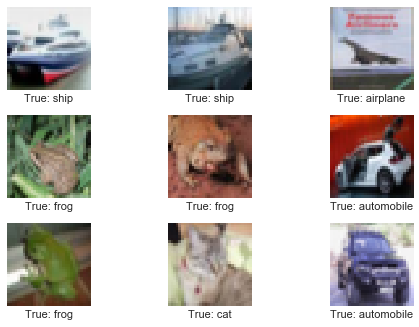

In [10]:
plot_images(images_test_for_print[1:10,:,:,:],cls_test_for_print[1:10], cls_pred=None, smooth=False)

In [11]:
images_train, cls_train, labels_train = load_training_data()
images_test, cls_test, labels_test = load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [12]:
# Check the data shape 
images_train.shape
images_test.shape
labels_train.shape   ##label_train and test_train is the one-hot coded label 
labels_test.shape

(50000, 32, 32, 3)

(10000, 32, 32, 3)

(50000, 10)

(10000, 10)

**Show the images after preprocessing**

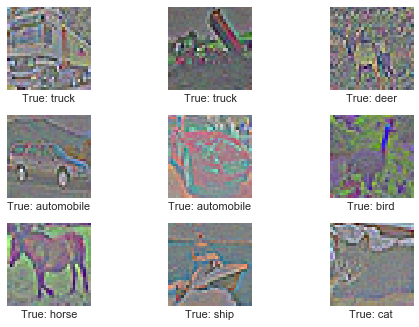

In [13]:
plot_images(images_train[1:10,:,:,:], cls_train[1:10], cls_pred=None, smooth=False)

## 3. Train the CNN Garph

In [23]:
# TRAIN
now = datetime.now()
dir_name = './CNN/log_{0}_{1}'.format(now.month,now.day)
export_dir = './CNN/savedmodel_{0}_{1}_{2}_{3}'.format(now.month,now.day,now.hour,now.second)
img_size_cropped = 24

batch_size = 256
num_iterations = 20000
opt_method = 'adam'
print_unit = 1000
learning_rate = 1e-4

In [24]:
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
with tf.Graph().as_default():
    global_step = tf.train.get_or_create_global_step()

    with tf.device('/cpu:0'):
        x = tf.placeholder(tf.float32, shape=[None, 32, 32, num_channels], name='x')
        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
        
        images = x
        images = pre_process(images=images, training=True)

        with tf.name_scope('model'):
            logits, pool1_cnn, pool2_cnn = compute_logits_cnn(images)

        with tf.name_scope('loss'):
            loss = compute_cross_entropy(logits=logits, y=y_true)

        with tf.name_scope('accuracy'):
            prediction,accuracy = compute_accuracy(logits=logits, y=y_true)

        with tf.name_scope('opt'):
            opt = tf.train.AdamOptimizer(learning_rate)
            train_step = opt.minimize(loss)

        with tf.name_scope('summaries'):
            tf.summary.scalar('loss', loss)
            tf.summary.scalar('accuracy', accuracy)
            tf.summary.histogram('logit', logits)
            tf.summary.image('input', tf.reshape(images, [-1, img_size_cropped, img_size_cropped, num_channels]))
            summary_op = tf.summary.merge_all()

        saver = tf.train.Saver()

        sess2 = tf.Session()
        summary_writer = tf.summary.FileWriter(dir_name, sess2.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess2.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')

        try:
            print("Trying to restore last checkpoint ...")

            # Use TensorFlow to find the latest checkpoint - if any.
            last_chk_path = tf.train.latest_checkpoint(checkpoint_dir='./CNN/model/')

            # Try and load the data in the checkpoint.
            saver.restore(sess2, save_path=last_chk_path)

            # If we get to this point, the checkpoint was successfully loaded.
            print("Restored checkpoint from:", last_chk_path)
        except:
            # If the above failed for some reason, simply
            # initialize all the variables for the TensorFlow graph.
            print("Failed to restore checkpoint. Initializing variables instead.")
            sess2.run(tf.global_variables_initializer())

        for i in range(num_iterations):

            X_batch, y_batch = random_batch()

            _, summary = sess2.run((train_step, summary_op),
                                    feed_dict={x: X_batch, y_true: y_batch})

            if i%print_unit==0:
                summary_writer_train.add_summary(summary, i)

                (train_error, train_accuracy, train_logits) = sess2.run((loss, accuracy, logits), {x: X_batch, y_true: y_batch})
                print("\rStep {0:3d}: training accuracy {1:0.4f}".format(i, train_accuracy), flush=True)
                print("\rStep {0:3d}: training loss {1:0.4f}".format(i, train_error), flush=True)

                (val_error, val_accuracy, summary) = sess2.run((loss, accuracy,summary_op), {x:images_test, y_true:labels_test})
                print("\rStep {0:3d}: val accuracy {1:0.4f}".format(i, val_accuracy), flush=True)
                print("\rStep {0:3d}: val loss {1:0.4f}".format(i, val_error), flush=True)
                summary_writer_val.add_summary(summary, i)
                saver.save(sess2, './CNN/model/model_iter', global_step=i)

        save_path = saver.save(sess2, "./CNN/model/final_model.ckpt")
        builder.add_meta_graph_and_variables(sess2, ["foo-tag"])

builder.save()

<tf.Tensor 'summaries/loss:0' shape=() dtype=string>

<tf.Tensor 'summaries/accuracy:0' shape=() dtype=string>

<tf.Tensor 'summaries/logit:0' shape=() dtype=string>

<tf.Tensor 'summaries/input:0' shape=() dtype=string>

Trying to restore last checkpoint ...
ERROR:tensorflow:Couldn't match files for checkpoint ./CNN/model/model_iter-0
Failed to restore checkpoint. Initializing variables instead.
Step   0: training accuracy 0.0820
Step   0: training loss 2.3028
Step   0: val accuracy 0.0969
Step   0: val loss 2.3026


'./CNN/model/model_iter-0'

Step 1000: training accuracy 0.2305
Step 1000: training loss 2.0392
Step 1000: val accuracy 0.2363
Step 1000: val loss 2.0306


'./CNN/model/model_iter-1000'

Step 2000: training accuracy 0.2422
Step 2000: training loss 2.0328
Step 2000: val accuracy 0.2656
Step 2000: val loss 1.9404


'./CNN/model/model_iter-2000'

Step 3000: training accuracy 0.2773
Step 3000: training loss 1.9693
Step 3000: val accuracy 0.2930
Step 3000: val loss 1.9133


'./CNN/model/model_iter-3000'

Step 4000: training accuracy 0.3906
Step 4000: training loss 1.8074
Step 4000: val accuracy 0.3468
Step 4000: val loss 1.7972


'./CNN/model/model_iter-4000'

Step 5000: training accuracy 0.3359
Step 5000: training loss 1.7446
Step 5000: val accuracy 0.3730
Step 5000: val loss 1.7178


'./CNN/model/model_iter-5000'

Step 6000: training accuracy 0.3906
Step 6000: training loss 1.6704
Step 6000: val accuracy 0.3829
Step 6000: val loss 1.7096


'./CNN/model/model_iter-6000'

Step 7000: training accuracy 0.3633
Step 7000: training loss 1.7834
Step 7000: val accuracy 0.4064
Step 7000: val loss 1.6628


'./CNN/model/model_iter-7000'

Step 8000: training accuracy 0.3789
Step 8000: training loss 1.6765
Step 8000: val accuracy 0.4223
Step 8000: val loss 1.6231


'./CNN/model/model_iter-8000'

Step 9000: training accuracy 0.4531
Step 9000: training loss 1.5475
Step 9000: val accuracy 0.4345
Step 9000: val loss 1.5851


'./CNN/model/model_iter-9000'

Step 10000: training accuracy 0.4375
Step 10000: training loss 1.5788
Step 10000: val accuracy 0.4347
Step 10000: val loss 1.5829


'./CNN/model/model_iter-10000'

Step 11000: training accuracy 0.4062
Step 11000: training loss 1.6415
Step 11000: val accuracy 0.4327
Step 11000: val loss 1.6007


'./CNN/model/model_iter-11000'

Step 12000: training accuracy 0.4883
Step 12000: training loss 1.4521
Step 12000: val accuracy 0.4575
Step 12000: val loss 1.5293


'./CNN/model/model_iter-12000'

Step 13000: training accuracy 0.4609
Step 13000: training loss 1.5717
Step 13000: val accuracy 0.4678
Step 13000: val loss 1.5107


'./CNN/model/model_iter-13000'

Step 14000: training accuracy 0.4766
Step 14000: training loss 1.5711
Step 14000: val accuracy 0.4615
Step 14000: val loss 1.5308


'./CNN/model/model_iter-14000'

Step 15000: training accuracy 0.4688
Step 15000: training loss 1.4281
Step 15000: val accuracy 0.4882
Step 15000: val loss 1.4516


'./CNN/model/model_iter-15000'

Step 16000: training accuracy 0.4805
Step 16000: training loss 1.5119
Step 16000: val accuracy 0.4823
Step 16000: val loss 1.4602


'./CNN/model/model_iter-16000'

Step 17000: training accuracy 0.5000
Step 17000: training loss 1.3765
Step 17000: val accuracy 0.4988
Step 17000: val loss 1.4232


'./CNN/model/model_iter-17000'

Step 18000: training accuracy 0.5352
Step 18000: training loss 1.4540
Step 18000: val accuracy 0.4930
Step 18000: val loss 1.4280


'./CNN/model/model_iter-18000'

Step 19000: training accuracy 0.5195
Step 19000: training loss 1.3705
Step 19000: val accuracy 0.5031
Step 19000: val loss 1.3885


'./CNN/model/model_iter-19000'

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./CNN/savedmodel_12_14_17_8\\saved_model.pb'


b'./CNN/savedmodel_12_14_17_8\\saved_model.pb'

## 4. Evaluate the CNN Graph

In [25]:
pool1_cnn, pool2_cnn 

(<tf.Tensor 'model/pool1:0' shape=(?, 12, 12, 64) dtype=float32>,
 <tf.Tensor 'model/pool1_1:0' shape=(?, 6, 6, 64) dtype=float32>)

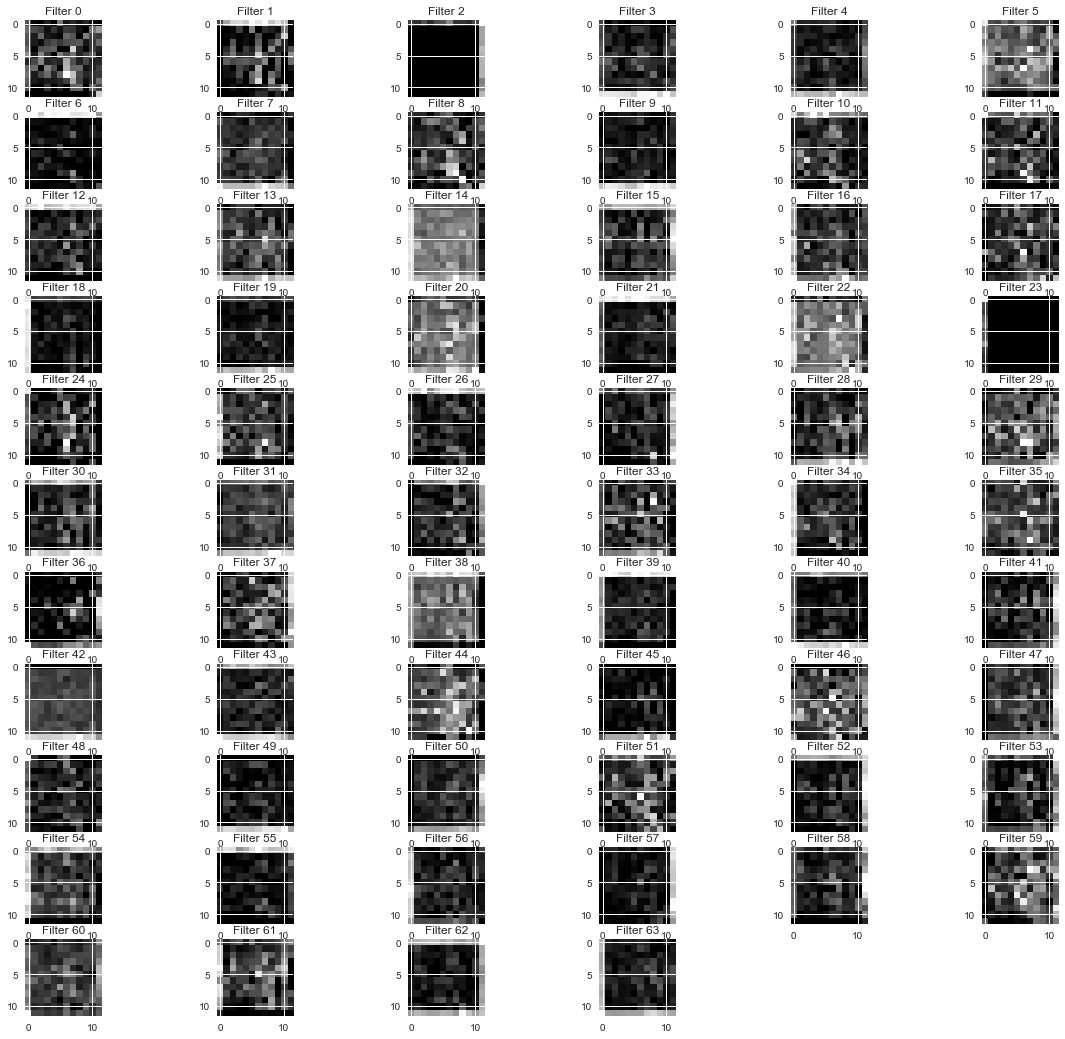

In [26]:
getActivations(sess2,pool1_cnn,images_test)

Confusion Matrix as numbers:
[567  79 106  16  23  15   7  29 105  53] (0) airplane
[ 44 645  23  17  30  10  12  30  57 132] (1) automobile
[ 89  32 423  33 104 115  69 102  16  17] (2) bird
[ 45  48 116 203  83 251  74 114  18  48] (3) cat
[ 38  44  72  35 443  42  65 208  12  41] (4) deer
[ 16  25 112 111  63 483  16 152   6  16] (5) dog
[ 11  20  92  48 120  39 613  30  18   9] (6) frog
[  9  21  64  28  76 116  11 621   4  50] (7) horse
[106 128  36  16  15   8   7   8 577  99] (8) ship
[ 29 119  18   9  25  13   7  57  52 671] (9) truck
Plot Confusion Matrix:


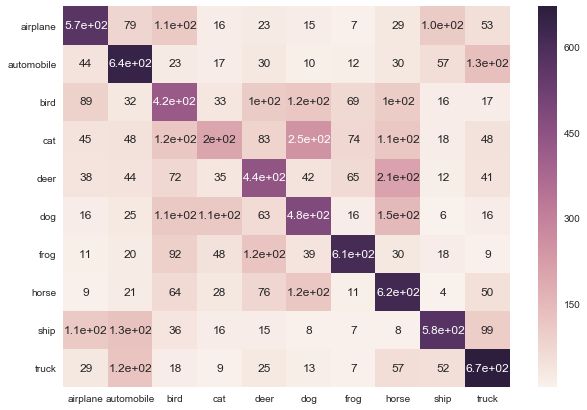

In [30]:
Test_Anlaysis(sess2,images_test, labels_test, cls_test)

## 5. Train the NIN Graph

In [38]:
now = datetime.now()

#dir_name = 'log_{0}_{1}'.format(now.month,now.day)
dir_name = './NIN/log_{0}_{1}'.format(now.month,now.day)
export_dir = './NIN/savedmodel_{0}_{1}_{2}_{3}'.format(now.month,now.day,now.hour,now.second)

img_size_cropped = 24
batch_size = 256
num_iterations = 20000
print_unit = 1000
opt_method = 'adam'

In [39]:
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
tf.reset_default_graph()
with tf.Graph().as_default():
    
    global_step = tf.train.get_or_create_global_step()

    # Get images and labels for CIFAR-10.
    # Force input pipeline to CPU:0 to avoid operations sometimes ending up on
    # GPU and resulting in a slow down.
    
    with tf.device('/cpu:0'):
        # We build the model here as before
        x= tf.placeholder(tf.float32, shape=[None,32,32, num_channels], name='x')
        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
        
        images = pre_process(images=x, training=True)
        
        with tf.name_scope('model'):
            logits,conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3 = compute_logits_NIN(images)

            print('conv1:',conv1.shape,
                  'cccp1:',cccp1.shape,
                  'cccp2:',cccp2.shape,
                  'pool1:',pool1.shape,
                  'conv2:',conv2.shape,
                  'pool2:',pool2.shape,
                  'conv3:',conv3.shape,
                  'cccp5:',cccp5.shape)
            
        with tf.name_scope('loss'):
            loss = compute_cross_entropy(logits=logits, y=y_true)
        with tf.name_scope('accuracy'):
            prediction,accuracy = compute_accuracy(logits=logits, y=y_true)
            
        
        with tf.name_scope('opt'):   
            if opt_method == 'sgd':
                opt = tf.train.GradientDescentOptimizer(0.5)
            elif opt_method == 'rms':
                opt = tf.train.RMSPropOptimizer(.001)
            elif opt_method == 'adam':
                opt = tf.train.AdamOptimizer(1e-4)
            train_step = opt.minimize(loss)
                
        with tf.name_scope('summaries'):
            # create summary for loss and accuracy
            tf.summary.scalar('loss', loss) 
            tf.summary.scalar('accuracy', accuracy)
            # create summary for logits
            tf.summary.histogram('logits', logits)
            # create summary for input image
            tf.summary.image('input', tf.reshape(images, [-1,img_size_cropped,img_size_cropped, num_channels]))
            summary_op = tf.summary.merge_all()
    
        saver = tf.train.Saver()    ##Save the model
        
        sess = tf.Session()
    
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
    
        try:
            print("Trying to restore last checkpoint ...")

            # Use TensorFlow to find the latest checkpoint - if any.
            last_chk_path = tf.train.latest_checkpoint(checkpoint_dir='./NIN/model/')

            # Try and load the data in the checkpoint.
            saver.restore(sess, save_path=last_chk_path)

            # If we get to this point, the checkpoint was successfully loaded.
            print("Restored checkpoint from:", last_chk_path)
            
        except:
            # If the above failed for some reason, simply
            # initialize all the variables for the TensorFlow graph.
            print("Failed to restore checkpoint. Initializing variables instead.")
            sess.run(tf.global_variables_initializer())
    
        for i in range(num_iterations):
            X_batch, y_batch = random_batch()
            
            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y_true: y_batch})
            
                
                # write the summary output to file
            if i%print_unit==0:
                
                summary_writer_train.add_summary(summary, i)                    
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y_true: y_batch})
                print("\rStep {0:3d}: training accuracy {1:0.4f}".format(i, train_error), flush=True)
                
                X_batch2 = images_test
                y_batch2 = labels_test
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch2, y_true:y_batch2})
                print("\rStep {0:3d}: val accuracy {1:0.4f}".format(i, val_error), flush=True)
                
                summary_writer_val.add_summary(summary, i)
                saver.save(sess, './NIN/model/model_iter', global_step=i)
                
        # Save the final model
        save_path = saver.save(sess, "./NIN/model/model.ckpt")
        builder.add_meta_graph_and_variables(sess,["foo-tag"])
builder.save()

conv1: (?, 24, 24, 96) cccp1: (?, 24, 24, 80) cccp2: (?, 24, 24, 48) pool1: (?, 12, 12, 48) conv2: (?, 12, 12, 96) pool2: (?, 6, 6, 96) conv3: (?, 6, 6, 96) cccp5: (?, 6, 6, 96)


<tf.Tensor 'summaries/loss:0' shape=() dtype=string>

<tf.Tensor 'summaries/accuracy:0' shape=() dtype=string>

<tf.Tensor 'summaries/logits:0' shape=() dtype=string>

<tf.Tensor 'summaries/input:0' shape=() dtype=string>

Trying to restore last checkpoint ...
ERROR:tensorflow:Couldn't match files for checkpoint ./NIN/model/model.ckpt
Failed to restore checkpoint. Initializing variables instead.
Step   0: training accuracy 0.1016
Step   0: val accuracy 0.1000


'./NIN/model/model_iter-0'

Step 1000: training accuracy 0.1250
Step 1000: val accuracy 0.1415


'./NIN/model/model_iter-1000'

Step 2000: training accuracy 0.2305
Step 2000: val accuracy 0.2189


'./NIN/model/model_iter-2000'

Step 3000: training accuracy 0.2305
Step 3000: val accuracy 0.2550


'./NIN/model/model_iter-3000'

Step 4000: training accuracy 0.2930
Step 4000: val accuracy 0.2740


'./NIN/model/model_iter-4000'

Step 5000: training accuracy 0.2930
Step 5000: val accuracy 0.3156


'./NIN/model/model_iter-5000'

Step 6000: training accuracy 0.3438
Step 6000: val accuracy 0.3256


'./NIN/model/model_iter-6000'

Step 7000: training accuracy 0.3516
Step 7000: val accuracy 0.3603


'./NIN/model/model_iter-7000'

Step 8000: training accuracy 0.3750
Step 8000: val accuracy 0.3736


'./NIN/model/model_iter-8000'

Step 9000: training accuracy 0.3398
Step 9000: val accuracy 0.3844


'./NIN/model/model_iter-9000'

Step 10000: training accuracy 0.3320
Step 10000: val accuracy 0.3878


'./NIN/model/model_iter-10000'

Step 11000: training accuracy 0.4180
Step 11000: val accuracy 0.3935


'./NIN/model/model_iter-11000'

Step 12000: training accuracy 0.4414
Step 12000: val accuracy 0.4018


'./NIN/model/model_iter-12000'

Step 13000: training accuracy 0.4023
Step 13000: val accuracy 0.4190


'./NIN/model/model_iter-13000'

Step 14000: training accuracy 0.3633
Step 14000: val accuracy 0.4051


'./NIN/model/model_iter-14000'

Step 15000: training accuracy 0.4453
Step 15000: val accuracy 0.4158


'./NIN/model/model_iter-15000'

Step 16000: training accuracy 0.4219
Step 16000: val accuracy 0.4232


'./NIN/model/model_iter-16000'

Step 17000: training accuracy 0.4492
Step 17000: val accuracy 0.4127


'./NIN/model/model_iter-17000'

Step 18000: training accuracy 0.4453
Step 18000: val accuracy 0.4349


'./NIN/model/model_iter-18000'

Step 19000: training accuracy 0.4531
Step 19000: val accuracy 0.4328


'./NIN/model/model_iter-19000'

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./NIN/savedmodel_12_14_21_3\\saved_model.pb'


b'./NIN/savedmodel_12_14_21_3\\saved_model.pb'

## 6. Evaluate the CNN Graph

### 1. Show the shape of different layers

In [40]:
conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3

(<tf.Tensor 'model/Relu:0' shape=(?, 24, 24, 96) dtype=float32>,
 <tf.Tensor 'model/Relu_1:0' shape=(?, 24, 24, 80) dtype=float32>,
 <tf.Tensor 'model/Relu_2:0' shape=(?, 24, 24, 48) dtype=float32>,
 <tf.Tensor 'model/MaxPool:0' shape=(?, 12, 12, 48) dtype=float32>,
 <tf.Tensor 'model/Relu_3:0' shape=(?, 12, 12, 96) dtype=float32>,
 <tf.Tensor 'model/AvgPool:0' shape=(?, 6, 6, 96) dtype=float32>,
 <tf.Tensor 'model/Relu_4:0' shape=(?, 12, 12, 96) dtype=float32>,
 <tf.Tensor 'model/Relu_5:0' shape=(?, 12, 12, 96) dtype=float32>,
 <tf.Tensor 'model/Relu_6:0' shape=(?, 6, 6, 96) dtype=float32>,
 <tf.Tensor 'model/Relu_7:0' shape=(?, 6, 6, 96) dtype=float32>,
 <tf.Tensor 'model/Relu_8:0' shape=(?, 6, 6, 10) dtype=float32>,
 <tf.Tensor 'model/AvgPool_1:0' shape=(?, 1, 1, 10) dtype=float32>)

### 2. Visualize the Conv Layers

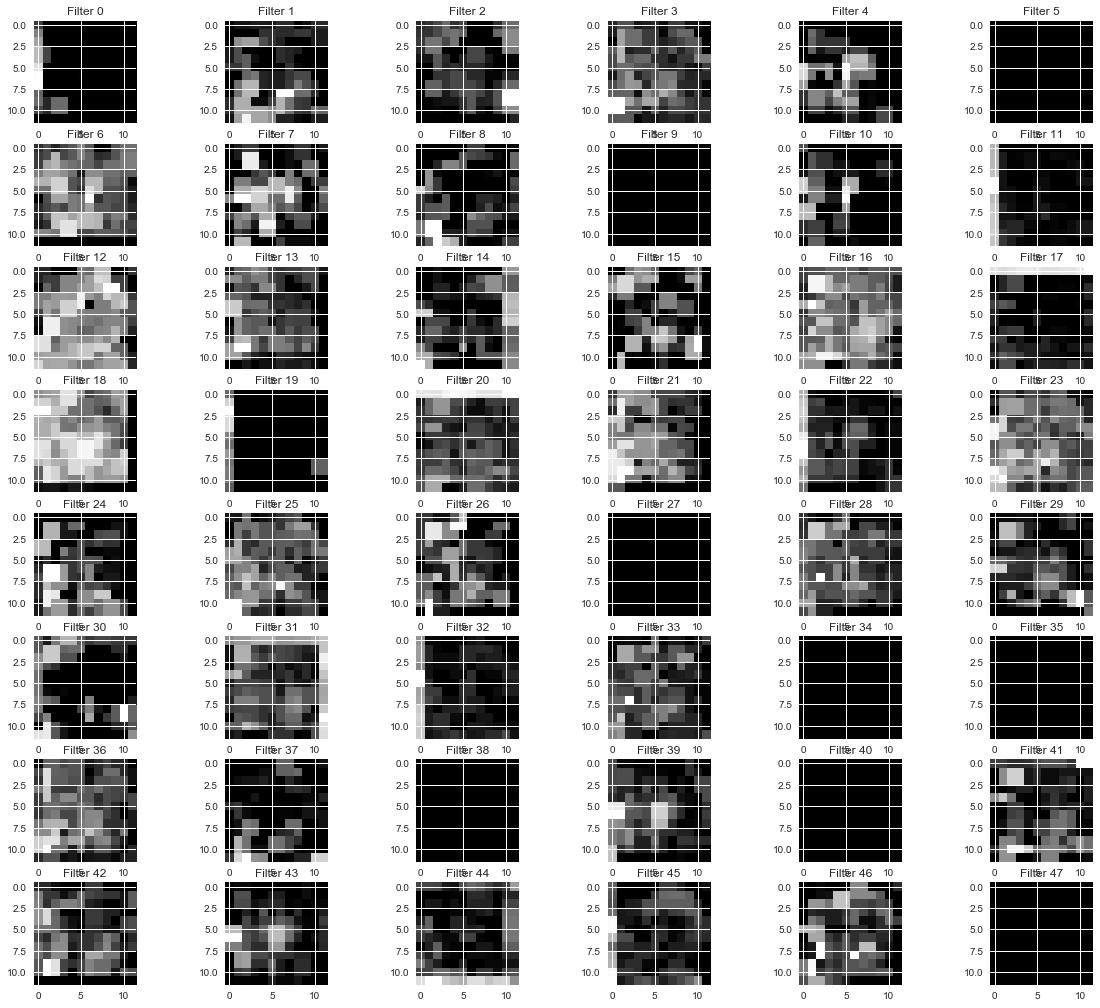

In [41]:
getActivations(sess,pool1,images_test)

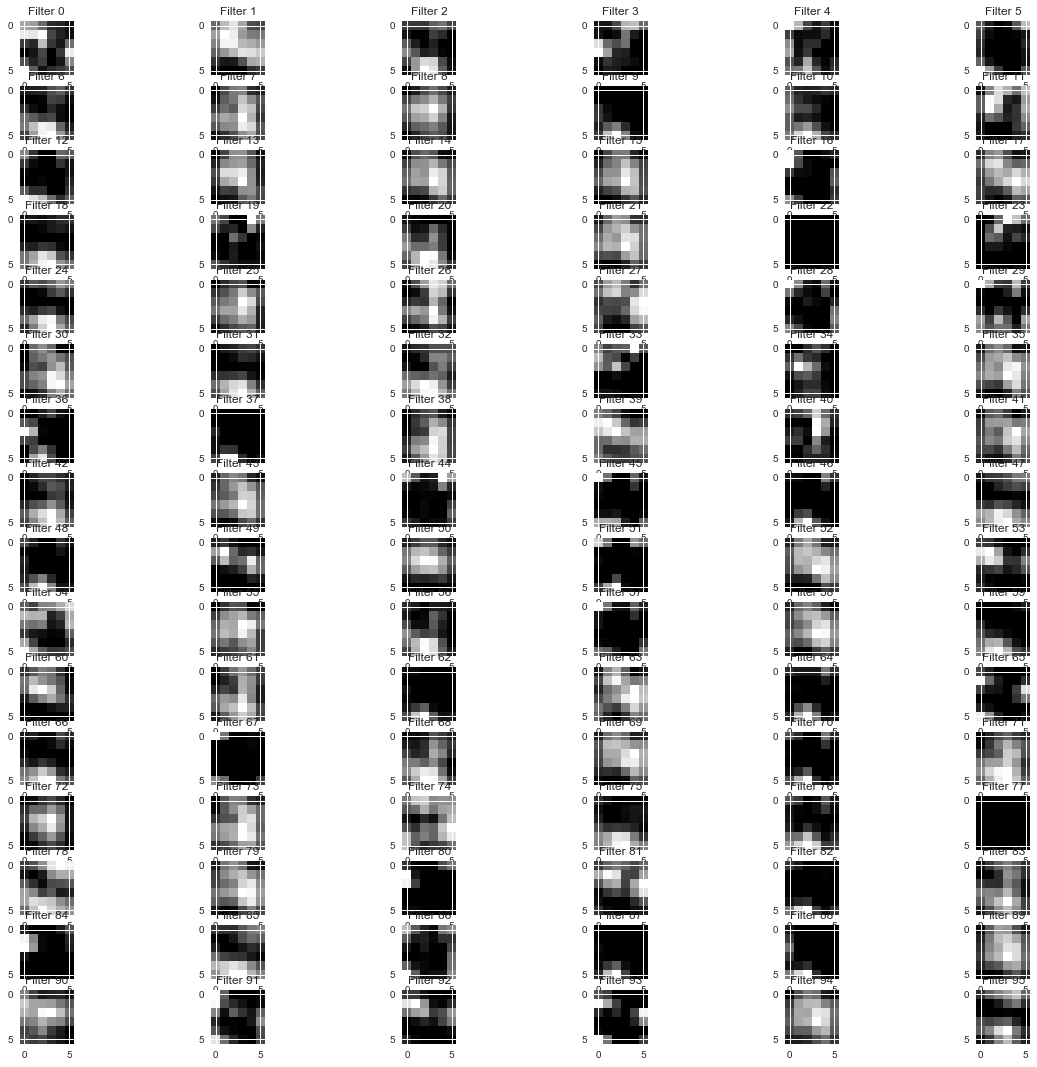

In [42]:
getActivations(sess,pool2,images_test)

### 3. Plot the confusion Matrix

Confusion Matrix as numbers:
[634 113  98  24  19  11  34  25   0  42] (0) airplane
[ 98 611  25  13  26  12  42  52   0 121] (1) automobile
[114  41 412  33  83  73 176  59   0   9] (2) bird
[ 65  51 116 163  63 196 237  82   0  27] (3) cat
[ 35  54  91  33 308  73 223 159   0  24] (4) deer
[ 28  29 115 101  65 408 127 116   0  11] (5) dog
[ 21  15  73  26  71  22 757  11   0   4] (6) frog
[ 33  52  60  37 120  92  74 492   0  40] (7) horse
[446 233  53  20  26  10  30  14   0 168] (8) ship
[ 57 141  17  26  35   7  29  70   0 618] (9) truck
Plot Confusion Matrix:


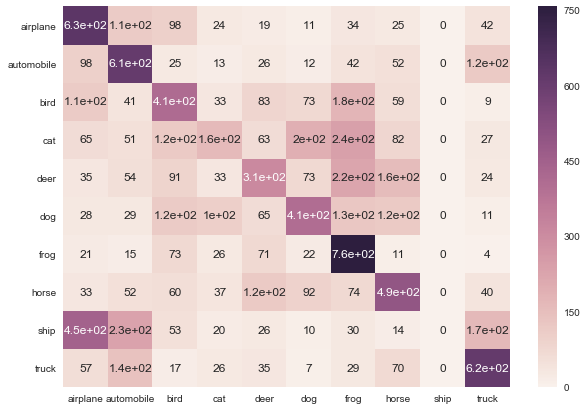

In [43]:
Test_Anlaysis(sess,images_test, labels_test, cls_test)